## Heart Attack Analysis Report: Group 44

### Introduction

Heart disease is a prevalent and life-threatening condition that affects millions of people worldwide. Early diagnosis and risk assessment are crucial in providing timely medical intervention and reducing the mortality associated with this condition. In our project, we aim to leverage a [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) containing hospital data from Cleveland, Hungary, Switzerland, and VA Long Beach. However, we will specifically choose to work with the Cleveland data as it contains the most hospital patient data. The dataset contains 14 health-related variables, including the presence or absence of heart disease as the categorical. Using classification modelling, this data offers us a valuable opportunity to explore its relationship with heart disease. Hence, we propose the question: Using KNN, how can we use medical data available to us to predict whether a patient has heart disease?

## Methods & Results

First, we load all of the packages with the functions that are necessary to work the following data analysis.

In [15]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
install.packages("kknn")
install.packages("GGally")
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We set a seed value in every code block that involves running the analysis to ensure that the randomness is reproducible. Next, we create a vector to rename the 14 columns from the original data set to make it human-readable.  

Then, we read in the heart disease data and store it as `heart_data`. However, for our analysis, we will only be using the following five predictor variables: `cp` (chest pain type), `trestbps` (resting blood pressure), `chol` (serum cholesterol levels), `fbs` (fasting blood sugar), and `restecg` (resting electrocardiogram results). The response variable here will be `num` (diagnosis of heart disease). 

The original data set characterizes a diagnosis of heart disease by the numbers 1, 2, 3, and 4 in varying levels of severity, and a diagnosis of no heart disease by the number 0. In our analysis, we simplify this by setting the diagnosis of heart disease: 0 = no heart disease; 1 = heart disease. 

In [16]:
set.seed(1)
# creating column names for our data as it does not contain
our_col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# reading in our data and storing as an object
heart_data <- read_csv("data/processed.cleveland.data", col_names = our_col_names) |>
    select(cp, trestbps, chol, fbs, restecg, num) |>
    mutate(num = ifelse(num %in% c(1, 2, 3, 4), 1, num)) |>
    mutate(num = as_factor(num),)
    
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cp,trestbps,chol,fbs,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,145,233,1,2,0
4,160,286,0,2,1
4,120,229,0,2,1
3,130,250,0,0,0
2,130,204,0,2,0
2,120,236,0,0,0


We start the initial splitting of the data into 80% training set and 20% testing set and store it as `train_data` and `test_data`, respectively.

Now, using the training data, we begin our preliminary exploratory data analysis of the five predictor variables we have chosen. Two of the predictor variables (`trestbps`, `chol`) are continuous, whereas the other three (`cp`, `fbs`, `restecg`) are discrete variables. We start examining the mean values of the `trestbps` and `chol` variables, as well as counting the number of patients who were diagnosed with or without heart disease. This gives us a sense of the average blood pressure and cholesterol levels of the patients, and it also allows us to gauge the number of patients involved - in other words, the size of this data set.

In [17]:
set.seed(1)

# prepare data for splitting
split_obj <- initial_split(heart_data, prop = 0.8, strata = num)

# split and extract data
train_data <- training(split_obj)
test_data <- testing(split_obj)


# calculcate summary statistics
summary_diagnosis <- train_data |>
    group_by(num) |>
    summarize(count = n()) |>
    pivot_wider(names_from = num,
                values_from = count)

# summary_diagnosis

summary_means <- train_data |>
    select(trestbps, chol) |>
    summarize_all(mean, na.rm = TRUE)

# summary_means

summary_table <- cbind(summary_means, summary_diagnosis) |>
    rename("resting blood pressure (mean)" = trestbps,
          "serum cholesterol (mean)" = chol,
          "no disease" = `0`,
          "disease" = `1`)
           
summary_table

resting blood pressure (mean),serum cholesterol (mean),no disease,disease
<dbl>,<dbl>,<int>,<int>
132.7727,246.4835,131,111


We continue our preliminary analysis on the training data by visualizing a scatter plot between the continuous variables, `trestbps` and `chol`, for any potential relationships. Visually, it appears that there is no distinct relationship between the two variables, and neither with the heart disease diagnosis.  

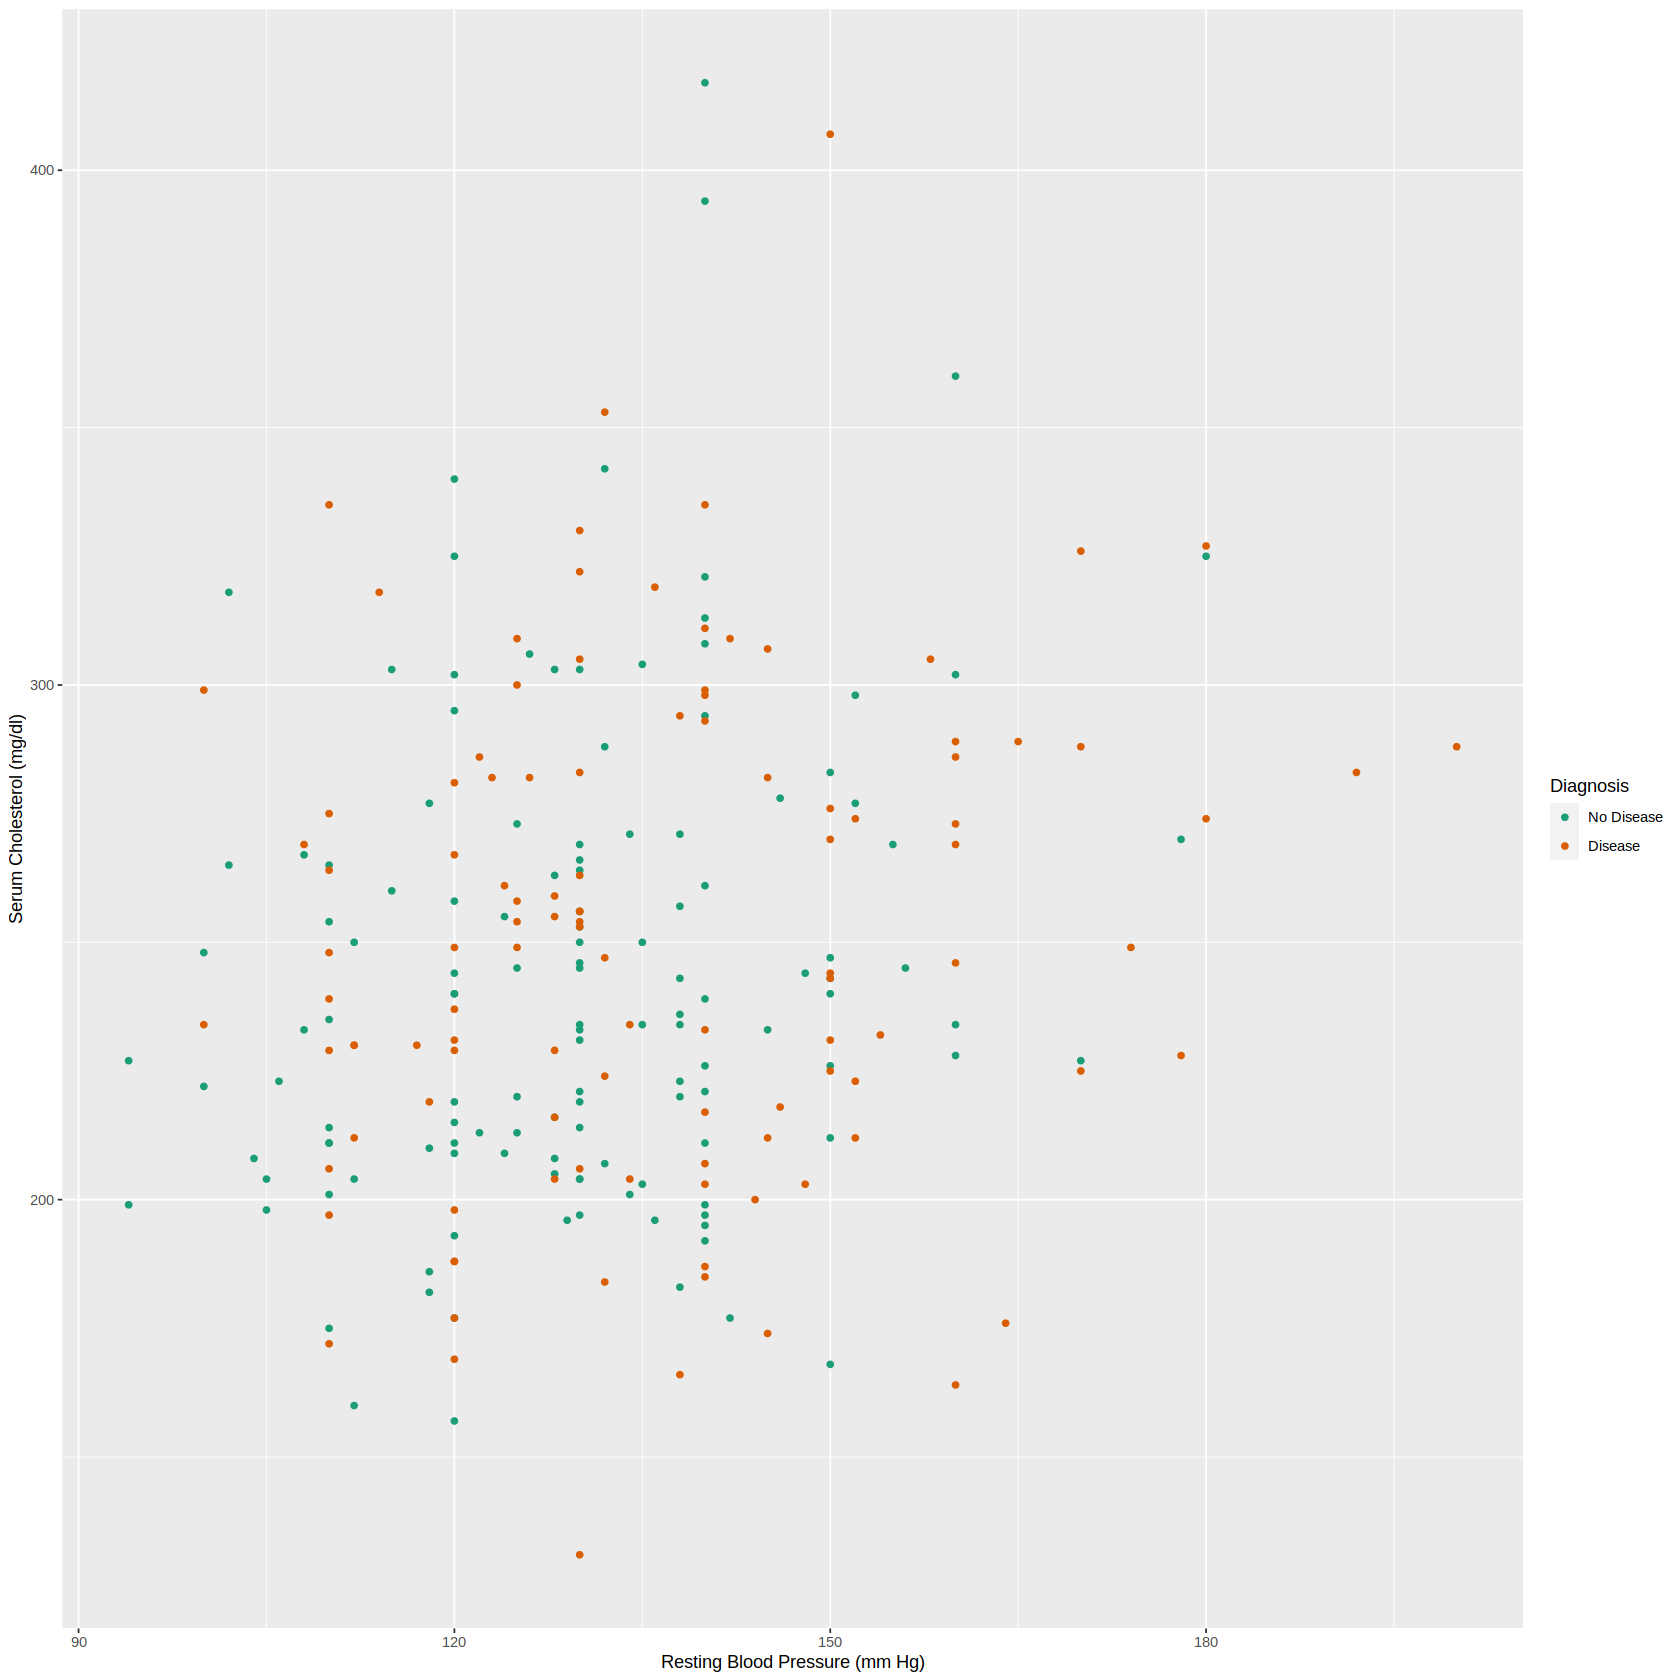

In [18]:
set.seed(1)
visualization1 <- train_data |>
    ggplot(aes(x=trestbps,  y=chol, colour= as_factor(num))) +
    geom_point() +
    labs(x="Resting Blood Pressure (mm Hg)", y="Serum Cholesterol (mg/dl)", colour = "Diagnosis") +
    scale_color_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

visualization1

Here, we visualize a bar plot of the proportions of patients diagnosed with and without heart disease based on the type of chest pain they reported, where

1 = typical angina,  
2 = atypical angina,  
3 = non-anginal pain,  
4 = asymptomatic.

It appears that majority of the patients who reported having no chest pain were the ones who had heart disease.

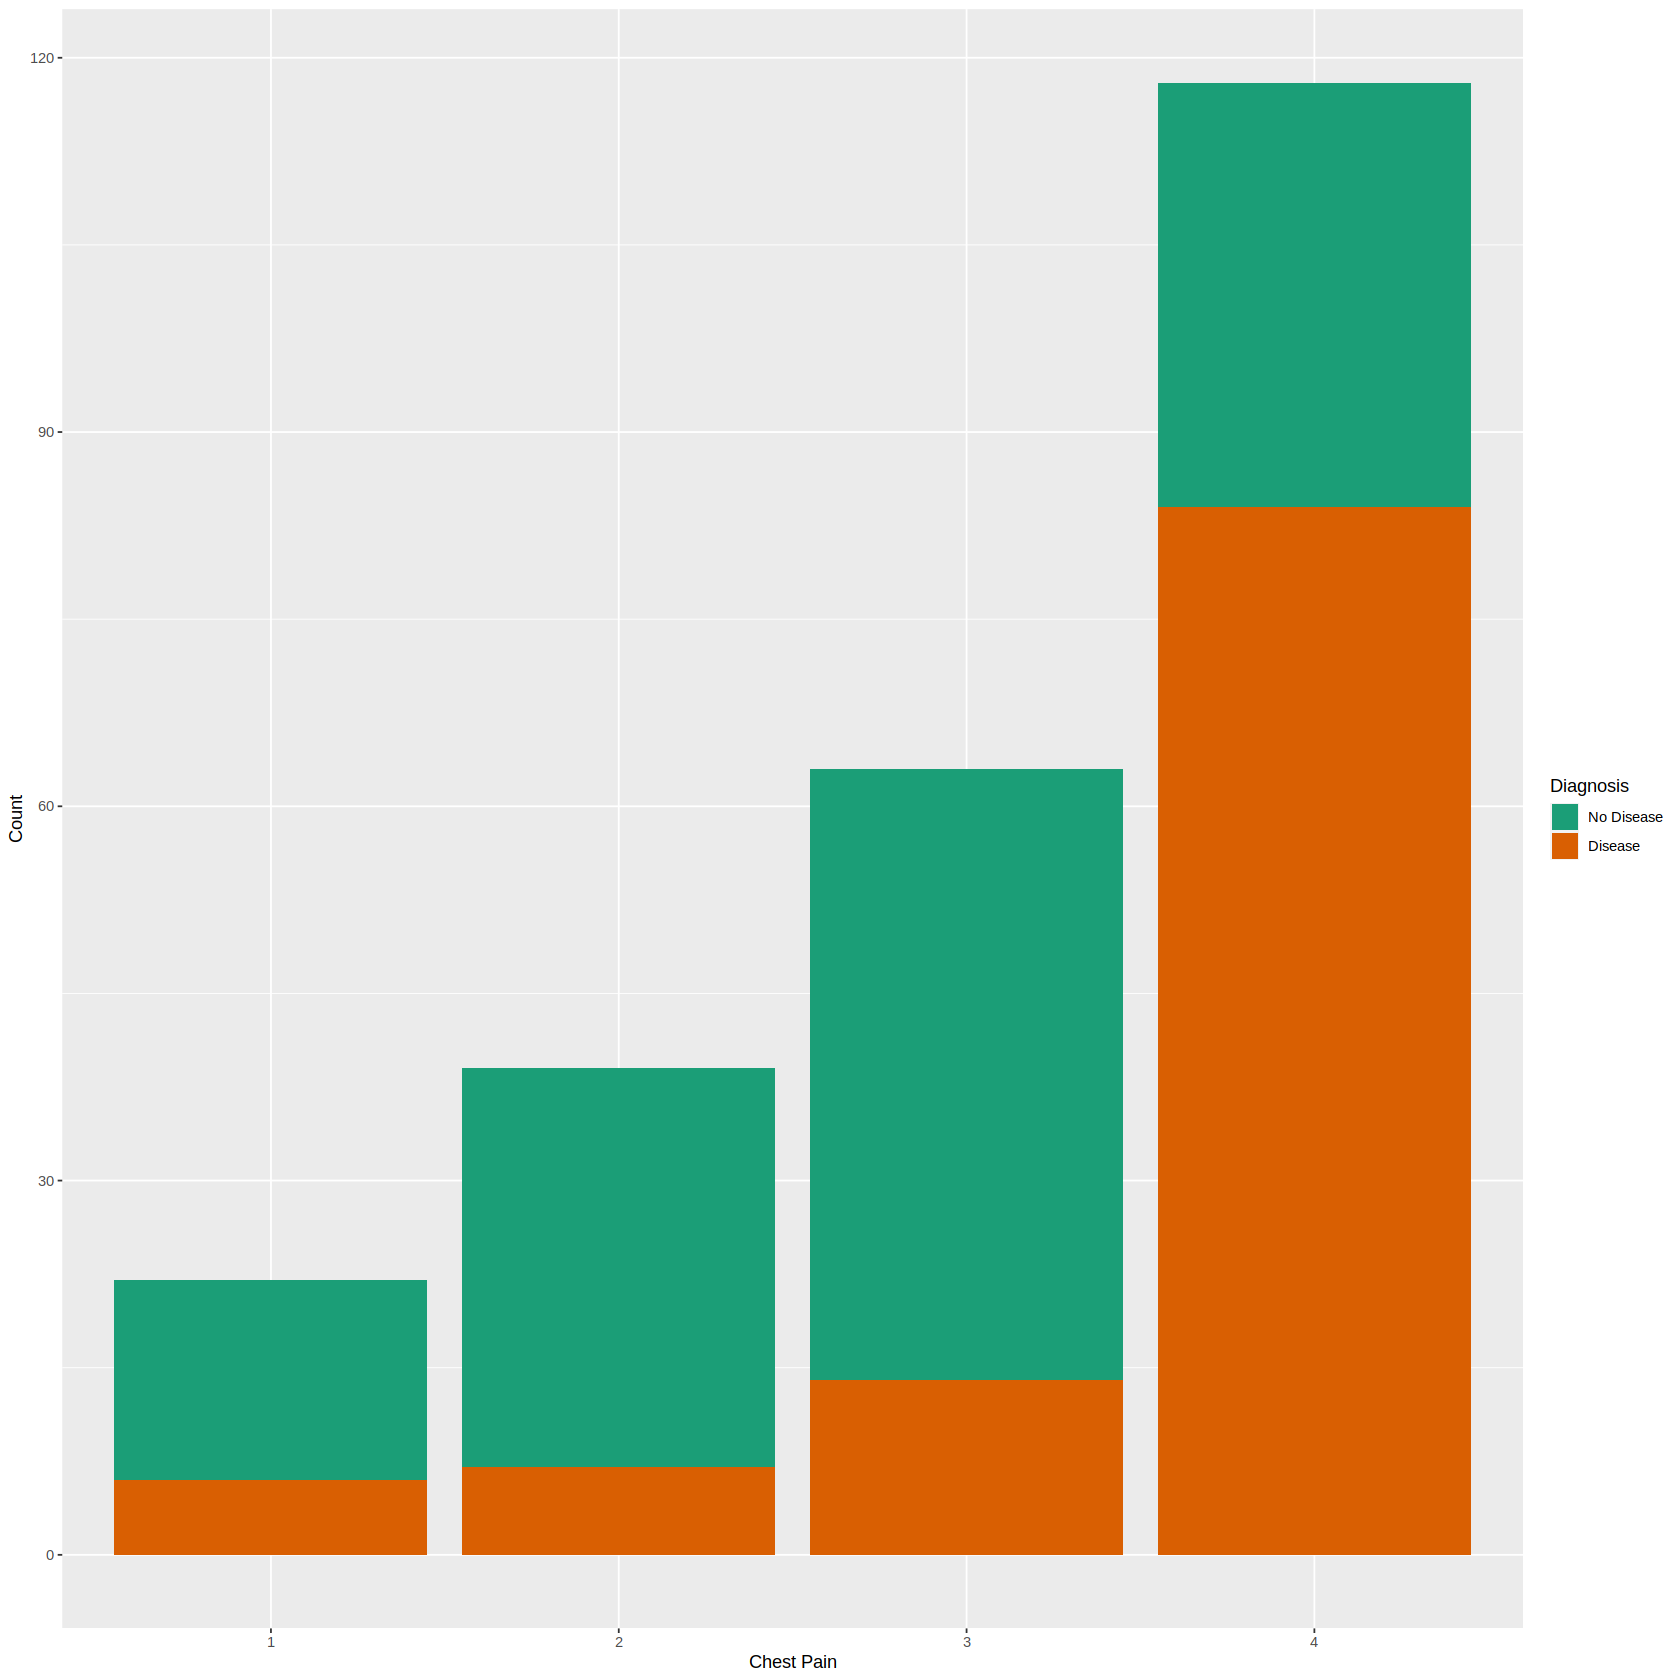

In [19]:
#9 cp: chest pain type
        #-- Value 1: typical angina
        #-- Value 2: atypical angina
        #-- Value 3: non-anginal pain
        #-- Value 4: asymptomatic

set.seed(1)
cat_cp <- train_data |>
    ggplot(aes(x = as_factor(cp), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Chest Pain", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_cp

Here, we visualize a bar plot of the proportions of patients diagnosed with and without heart disease based on their fasting blood sugar levels, where

0 = fasting blood sugar level $\leq$ 120 mg/dl,  
1 = fasting blood sugar level $>$ 120 mg/dl.

It appears that majority of the patients' fasting blood sugar levels were below 120mg/dl. There does not seem to be any indication of heart disease based on fasting blood sugar levels.

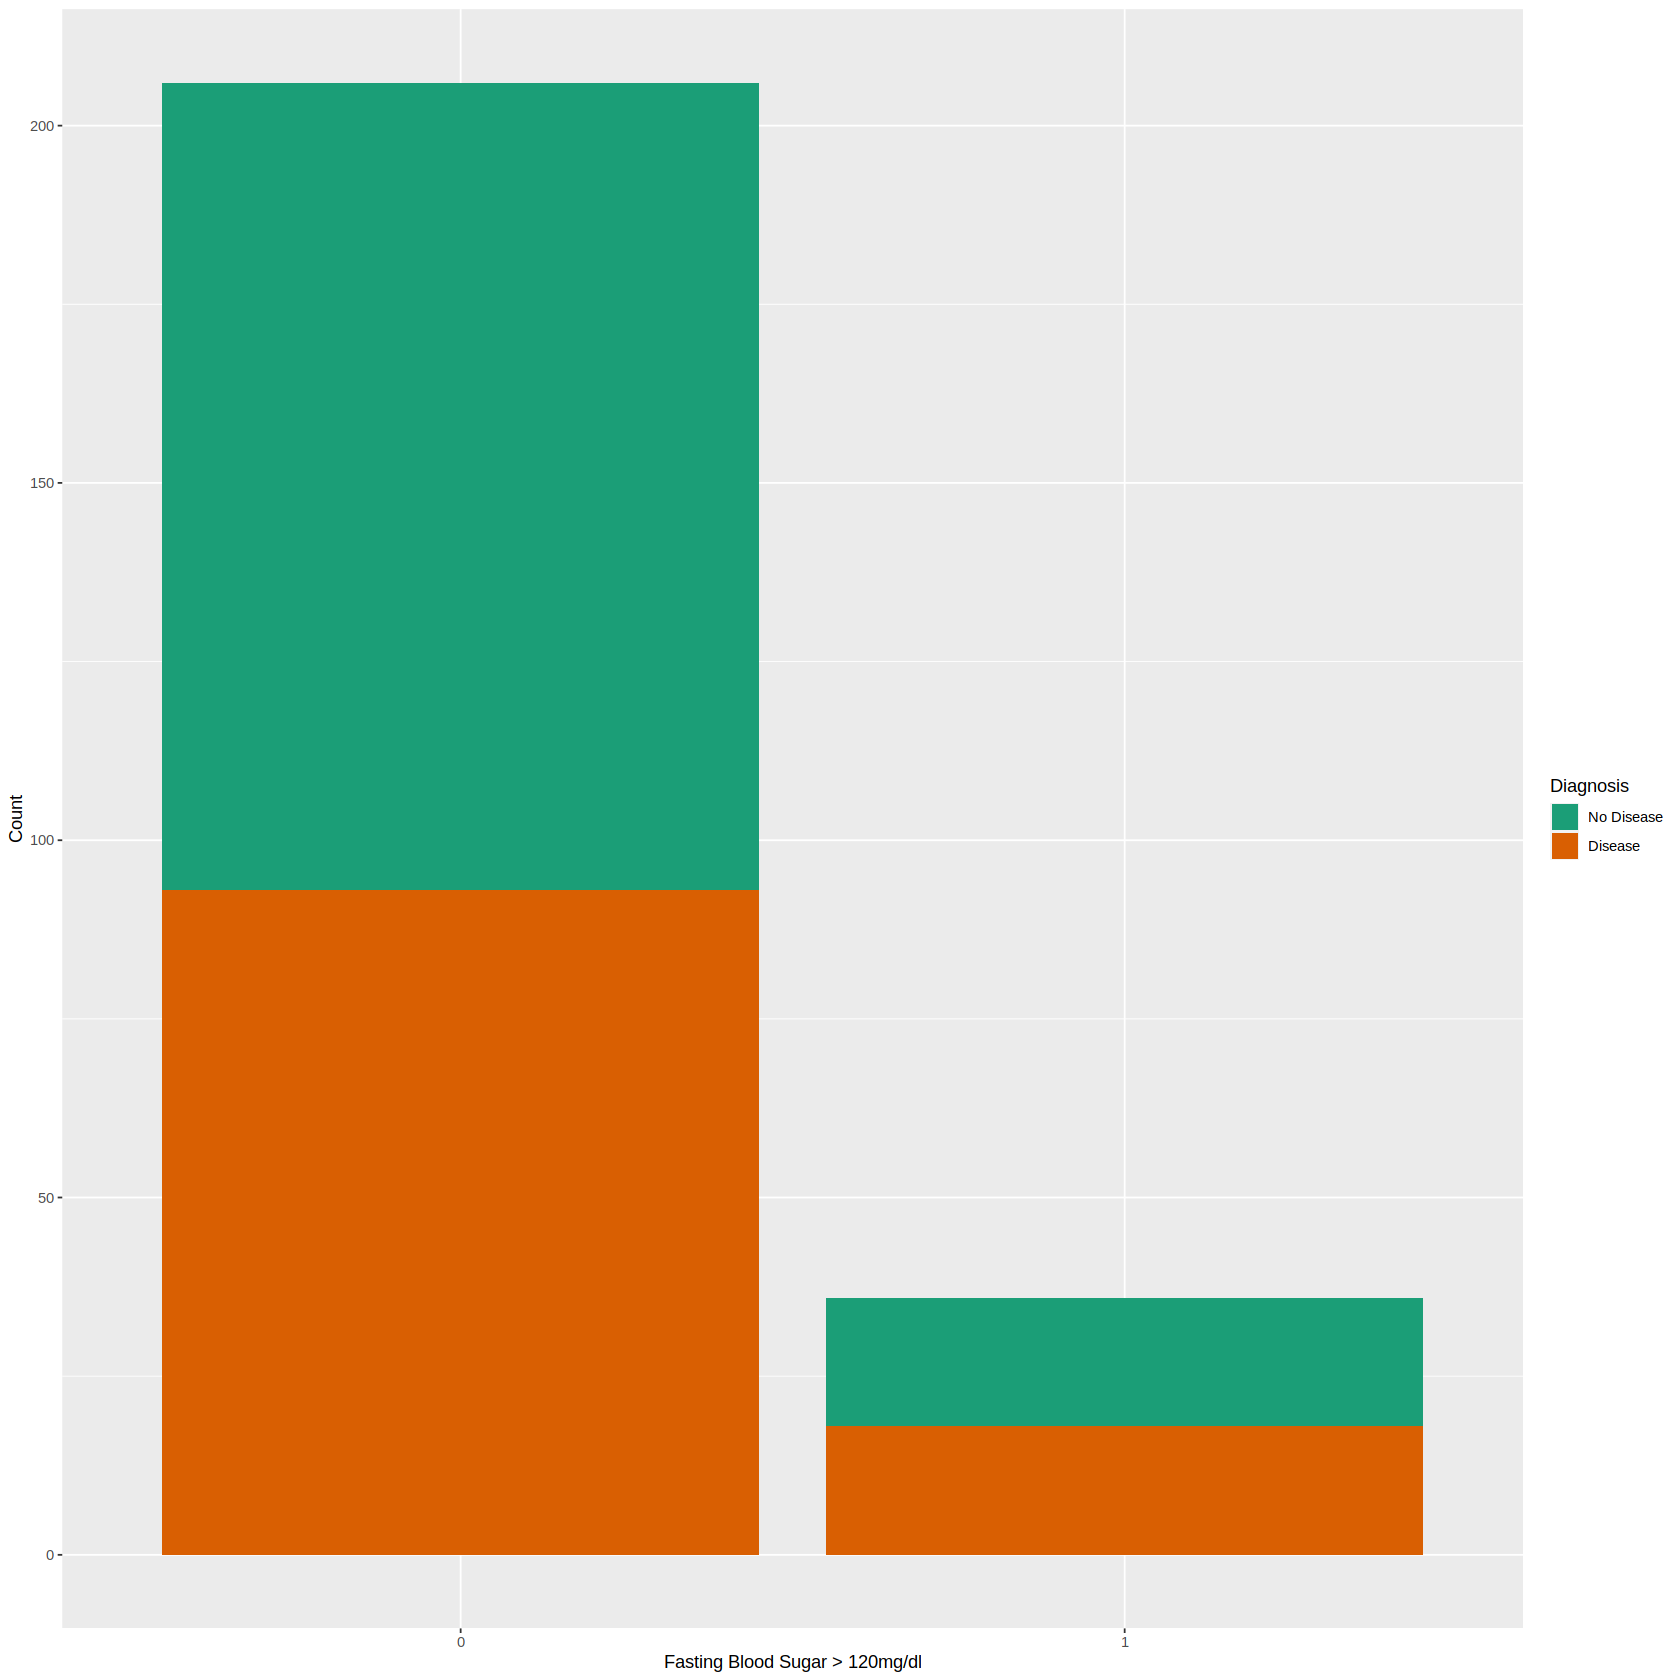

In [20]:
#16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
set.seed(1)
cat_fbs <- train_data |>
    ggplot(aes(x = as_factor(fbs), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Fasting Blood Sugar > 120mg/dl", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_fbs

Here, we visualize a bar plot of the proportion of patients diagnosed with and without heart disease based on their resting electrocardiographic results, where

0 = normal,  
1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of $>$ 0.05 mV),  
2 = showing probable or definite left ventricular hypertrophy by Estes' criteria.

It appears that most patients who showed ST-T wave abnormality, which also seemed to be extremely rare, and left ventricular hypertrophy had heart disease.

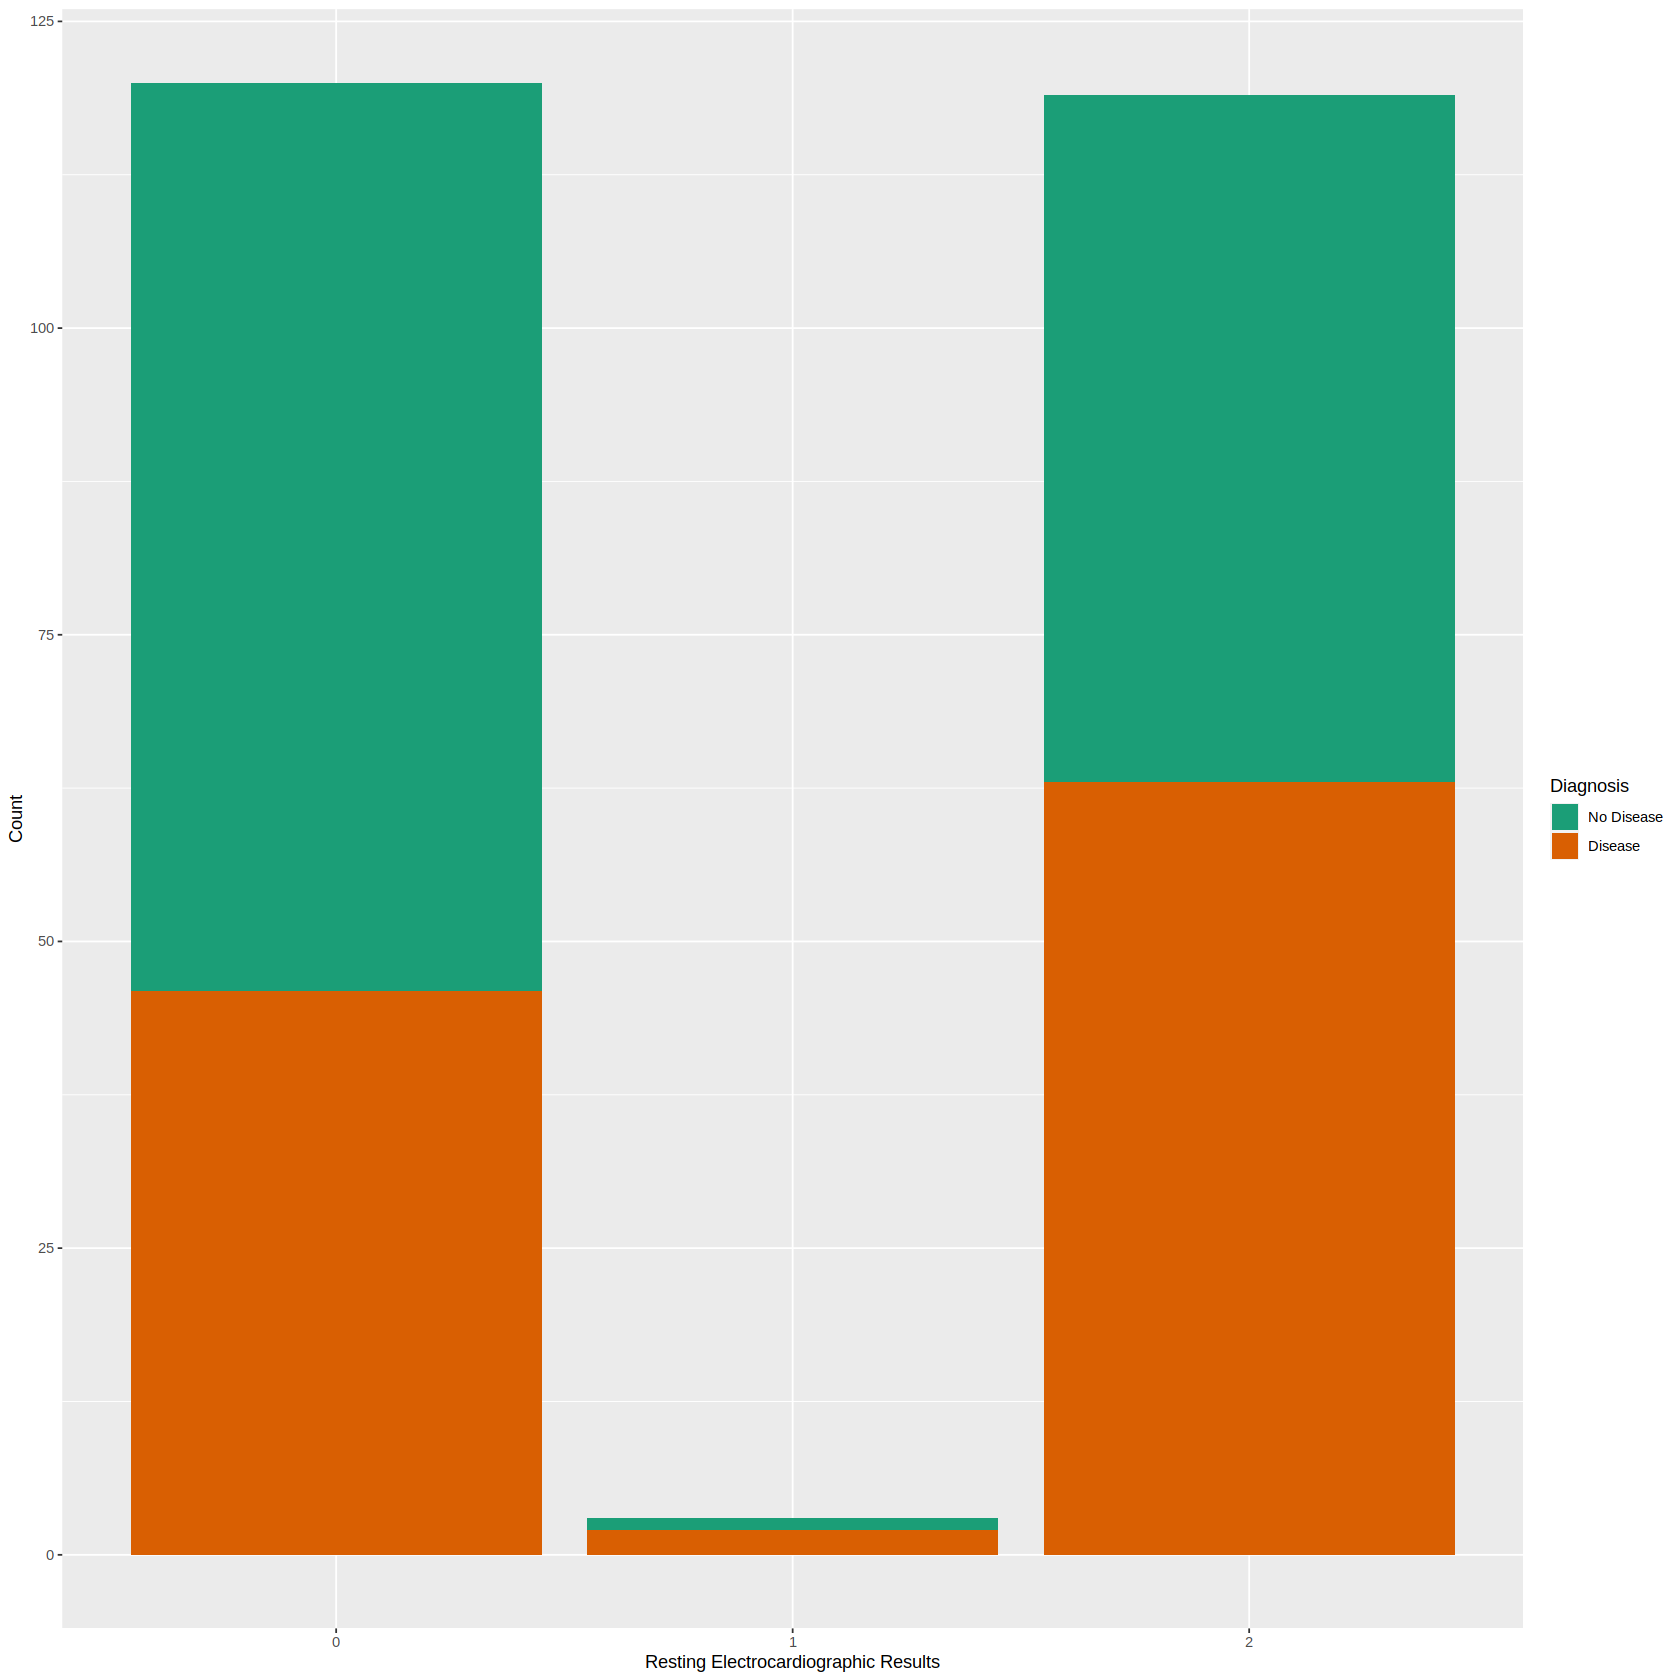

In [21]:
#19 restecg: resting electrocardiographic results
        #-- Value 0: normal
        #-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        #-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

set.seed(1)
cat_restecg <- train_data |>
    ggplot(aes(x = as_factor(restecg), fill = as_factor(num))) +
    geom_bar(stat = "count") +
    labs(x = "Resting Electrocardiographic Results", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_restecg

After visualizing the predictor variables through several plots, we now begin to tune our K-NN classifier to choose the optimal K-value. First, we create the recipe (`knn_recipe`) and tuning model specification (`knn_tune`) to combine them into a workflow (`knn_workflow`) afterwards. Next, we perform a 5-fold cross-validation (`heart_vfold`) and fit the model for each K-value from 1 to 30 to generate an estimate of each value's accuracy (`knn_results`), which is then plotted against K-values (`cross_val_plot`).

$title
[1] "Cross validation plot"

attr(,"class")
[1] "labels"

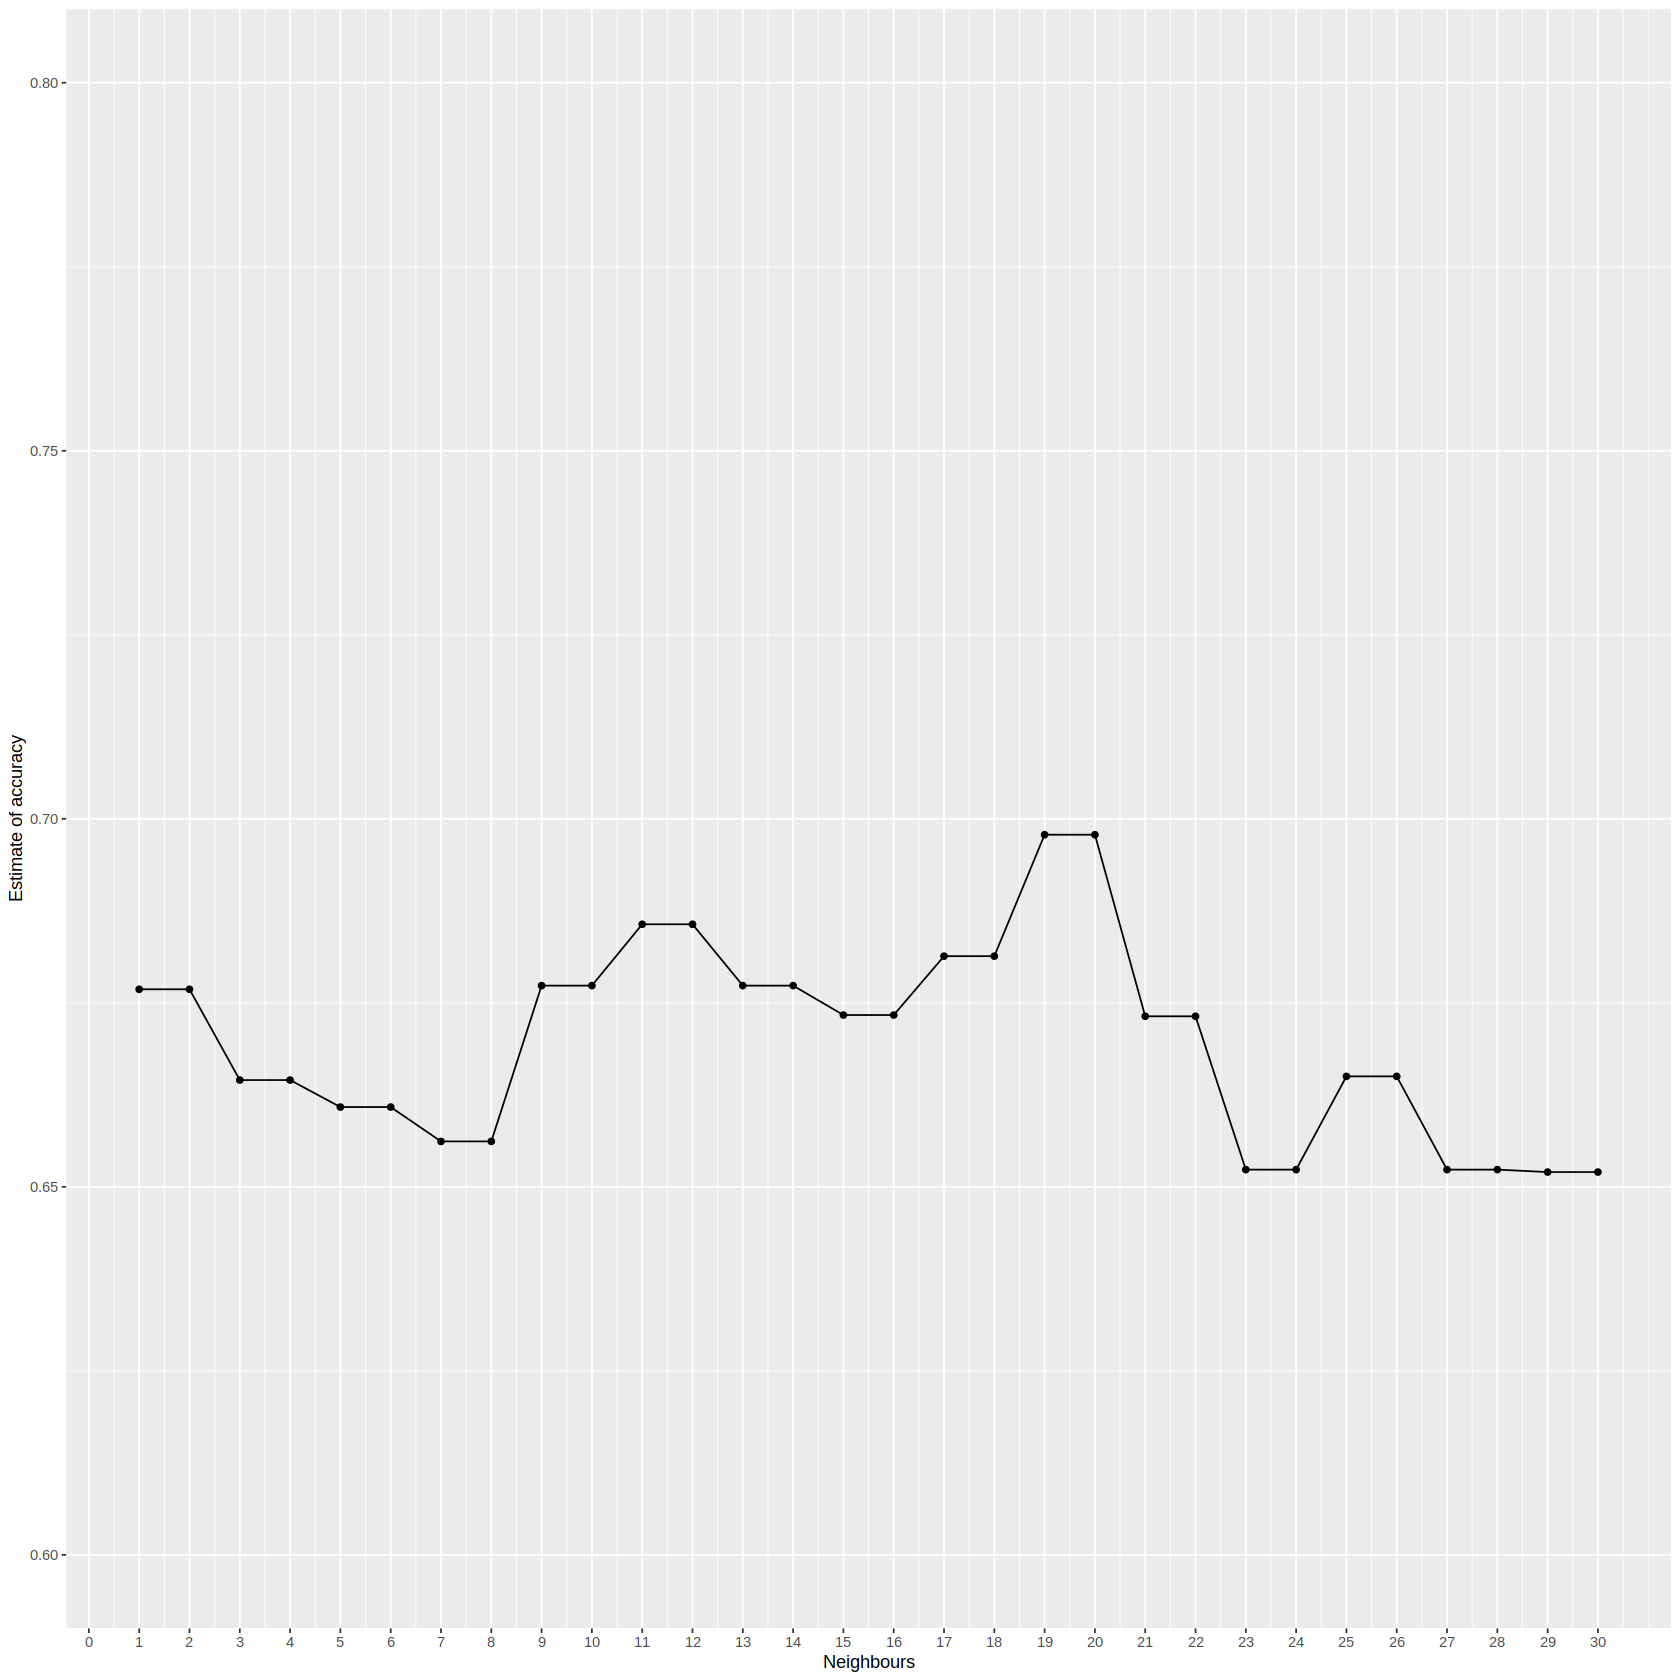

In [22]:
set.seed(1)

knn_recipe <- recipe(num ~., train_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune)

heart_vfold <- vfold_cv(train_data, v = 5, strata = num)

k_values <- tibble(neighbors=seq(from = 1, to = 30))

knn_results <- knn_workflow |>
    tune_grid(resamples = heart_vfold, grid = k_values) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbours", y="Estimate of accuracy")  + 
    scale_x_continuous(breaks = seq(from = 0, to = 30)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.6, 0.8)) # adjusting the y-axis +
    ggtitle("Cross validation plot")

cross_val_plot

From the graph above, the optimal K-value with the highest accuracy is around K = 19, so now we begin to train our K-NN classifier using 19 nearest-neighbours. We create a new model specification (`knn_spec`), as the one before was for tuning purposes. We add the recipe and model specification to the workflow (`heart_workflow`) and fit the training data (`heart_fit`) to finally complete the training of our classifier. 

In [23]:
# k = 19
set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |> 
      set_engine("kknn") |>
      set_mode("classification") 

heart_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

heart_fit <- heart_workflow |>
    fit(train_data)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.322314
Best kernel: rectangular
Best k: 19

We now use the trained classifier to predict the classifications of heart disease for each patient in the testing data. 

In [24]:
# test prediction
set.seed(1)
heart_test_predictions <- predict(heart_fit, test_data) |>
      bind_cols(test_data)

head(heart_test_predictions)

.pred_class,cp,trestbps,chol,fbs,restecg,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,2,120,236,0,0,0
1,4,140,268,0,2,1
1,4,120,354,0,0,0
0,2,120,263,0,0,0
0,3,172,199,1,0,0
0,4,140,239,0,0,0


From the predictions, we use the `metrics` function to assess our classifier's accuracy. It seems that our classifier has a 77% accuracy in correctly predicting the diagnosis for patients.

In [25]:
set.seed(1)
heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = num, estimate = .pred_class) |>
        filter(.metric == "accuracy")

heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7704918


Accuracy only tells us how many incorrect predictions the classifier makes in general, but it doesn't tell us specifically which kinds of predictions are incorrect. Hence, we examine the confusion matrix to calculate the precision and recall of the classifier. 

In this analysis, we are interested in whether a patient has heart disease, therefore we set the diagnosis of heart disease to be the positive label, and no heart disease to be the negative label. From the confusion matrix, the classifier made a total of 24 positive predictions, but only 19 of them were truly positive. Out of the total 28 positive test set observations, the classifier was only able to identify 19 of them correctly.  

In [26]:
set.seed(1)
heart_mat <- heart_test_predictions |> 
      conf_mat(truth = num, estimate = .pred_class)

heart_mat

          Truth
Prediction  0  1
         0 28  9
         1  5 19

The precision of our classifier was calculated at 79.2%, whereas the recall was calculated at 67.9%.

In [27]:
precision <- 19 / (5 + 19)
precision

recall <- 19 / (9 + 19)
recall

[1] 0.7916667

[1] 0.6785714

To complete our analysis, we use the `ggpairs` function to create a visualization that ties all of the variables into one cohesive plot. We also change the categorical variables into factors, so that `ggpairs` uses box plots and bar plots appropriately, instead of scatter plots.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


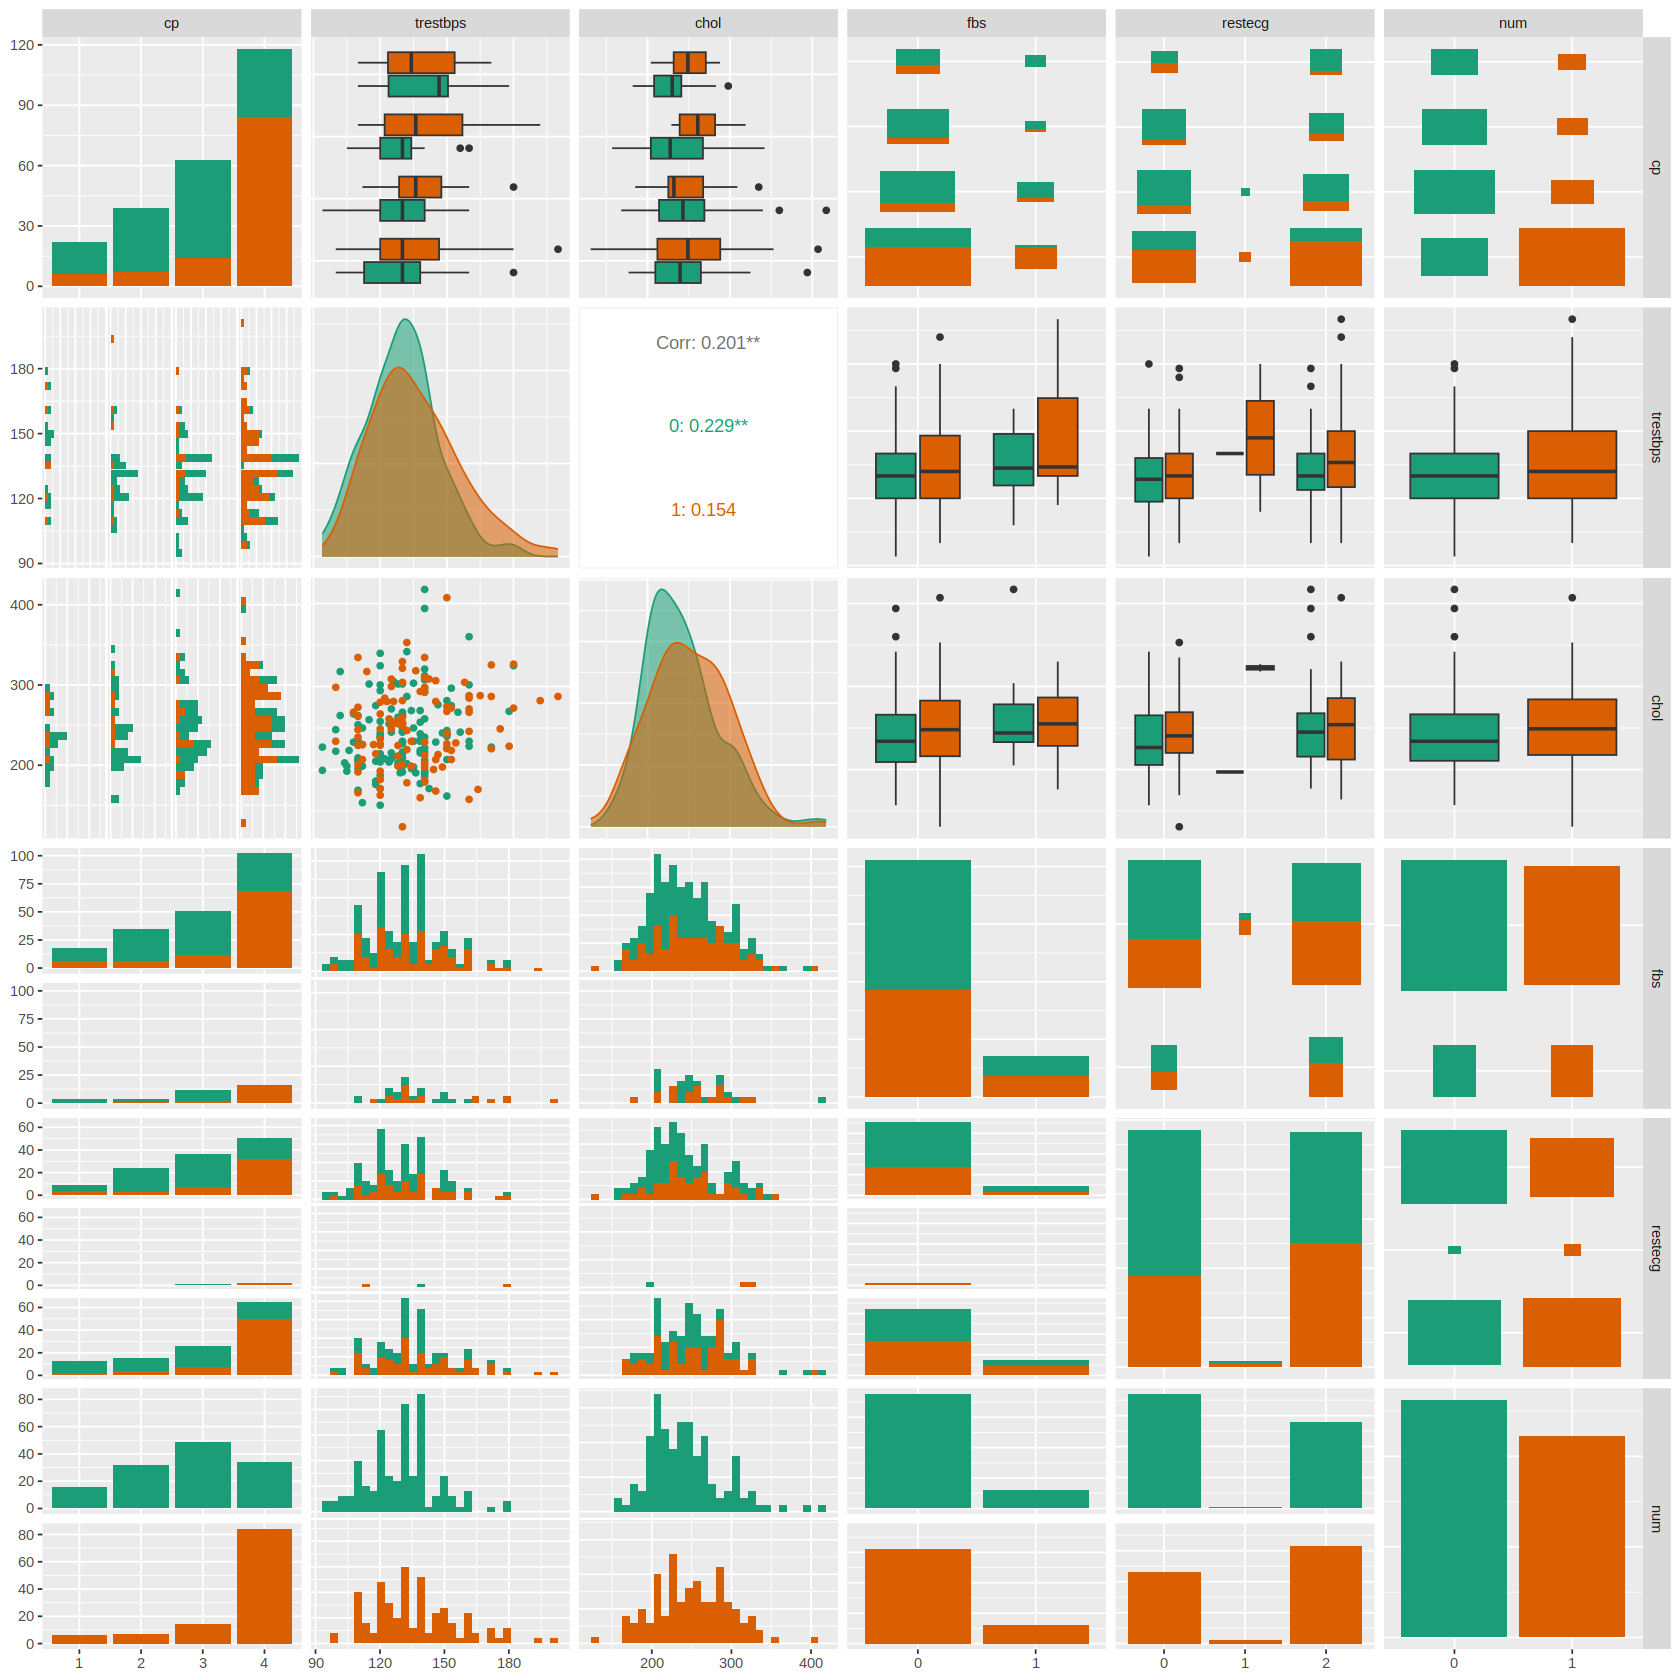

In [28]:
set.seed(1)
options(repr.plot.width = 14, repr.plot.height = 14)

heart_pairplot <- train_data |>
    mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg)) |>
    ggpairs(mapping = aes(color = num)) +
    scale_fill_brewer(palette = "Dark2") +
    scale_color_brewer(palette = "Dark2")

# adding transparency to density graphs 
heart_pairplot[2,2] <- heart_pairplot[2, 2] + aes(color = num, alpha = 0.5)
heart_pairplot[3,3] <- heart_pairplot[3, 3] + aes(color = num, alpha = 0.5)

# todo: scale_fill_brewer(palette = "Dark2")? 

# heart_pairplot2 <- train_data |>
#     ggpairs(mapping = aes(color = num, alpha = 0.5))

heart_pairplot

# heart_pairplot2 

# talk about the fact that we can't compare continuos and discrete

# trestbps (continuous) & chol (continuous) scatterplot: 0.201 corr | hard to tell
# - higher chol == higher trestbps for both heart disease + no disease





## Discussion

In the diagonal direction going from top left to bottom right, the bar plots and density plots show the proportions of the patients’ diagnosis with respect to each medical data variable. As mentioned previously, most patients with heart disease reported no symptoms of any chest pains. This was something we didn’t expect because often we associate diseases with some kind of pain involved, and in this case it was found to be the opposite. For resting blood pressure, heart disease patients have a much wider distribution of blood pressure levels as well as being slightly higher compared to patients without heart disease. This is expected because the narrowing of arteries, which ultimately overworks the heart muscle and increases the risk for heart disease, is known to be caused by high blood pressure [(High Blood Pressure Dangers: Hypertension’s Effects on Your Body, 2023)](https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/high-blood-pressure/art-20045868). For cholesterol levels, heart disease patients have much higher levels, on average, compared to patients without heart disease. This is also expected because according to [Soliman's (2018) study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6024687/), the risk of heart disease is greater with high blood cholesterol, which is normally a result of consuming foods rich in cholesterol and saturated fats. Moreover, we also found earlier that most patients had a fasting blood sugar level below 120 mg/dl but it does not appear to show any correlation with the diagnosis. From the resting ECG, a fairly large proportion of heart disease patients showed left ventricular hypertrophy. However, very few patients showed ST-T wave abnormality, and most of those who did were mainly heart disease patients. [Zhan et al.'s (2022)](https://www.frontiersin.org/articles/10.3389/fcvm.2022.930517/full) study found that people who showed ST-T wave abnormality had a significantly higher mortality rate from heart diseases compared to people who showed normal and other abnormal ECG results. Considering all of this, it seems that having asymptomatic chest pain, high blood pressure and cholesterol, and an abnormal ECG are likely the best indicators, in this case of variables, of heart disease to look out for in a diagnosis.

When we analyze the predictor variables pair-wise, we don't really get any insight in any trends or relationships because most of them are discrete, categorical variables. And the appropriate type of plots for these variables are box plots and bar plots. Thus, we cannot look at the correlation coefficients and infer the strengths of any relationships. However, there are only two predictor variables that are continuous, and we can analyze them. Between resting blood pressure and cholesterol levels, there is a very weak positive relationship with a correlation coefficient of 0.201. Before, we couldn't determine any correlation from just looking at it since the points were very scattered, but now the correlation coefficient tells us much more. It tells us that as resting blood pressure is higher, cholesterol levels are also higher, and vice versa when it is lower. The class-specific correlation coefficients (0.229 for no heart disease, and 0.154 for heart disease) are also quite similar to the overall coefficient (0.201), which means that the same positive relationship is observed in both groups of patients regardless of whether they have heart disease.

As for the performance of our classifier, its accuracy was 77%, while the precision was 79.2% and the recall was 67.9%. Of course, we can't have both high precision and high recall simultaneously, so there would have to be a compromise on either one. Because we are creating a classifier model that predicts whether a patient has heart disease, we want to ensure that the model has a high recall. In other words, if the patient actually has heart disease, we want the classifier to be able to identify it, whereas in terms of precision, the consequences are not so severe if it misclassifies a patient as having heart disease when they actually don't have it because this will get the patient to seek medical attention for a proper, professional diagnosis by a physician. Overall, both the precision and recall of our classifier is quite low, so we definitely would not want to implement this as a diagnostic tool to use yet until we can refine it and increase both the precision and recall to approximately greater than 95%. And of course, this classifier would be used in conjunction with a professional diagnosis. Furthermore, a potential factor that contributed to the low precision and recall may have been due to having too many predictor variables, or specifically a predictor variable that had a very weak indication of heart disease. An example of this would be the fasting blood sugar levels. Nonetheless, there needs to be further exploration of how the different predictor variables for heart disease affects the precision and recall of the classifier.  

cp and num: People reporting cp type 4 are likely to have heart disease (people that have heart disease are likely to have cp type 4)

trestbps and num: people with no disease have lower resting blood pressure

chol and num: overall patients with disease have higher cholesterol as seen by the peak being further
                distribution for patients with disease is less concentrated around mean? / 

fbs and num: most of the patients have a fbs below 120 units

restecg and num: weak relationship between restecg and num. 2 has more patients with disease than restecg 0 and vice versa



discuss whether this is what you expected to find?

discuss what impact could such findings have?

discuss what future questions could this lead to?    

## References